In [2]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
%matplotlib notebook
income = np.loadtxt('incomes.txt')

# Problem 1

(a) Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that bins are weighted using the normed = True option. Make sure you plot has correct x-axis and y-axis labels as well as a plot title.

<IPython.core.display.Javascript object>


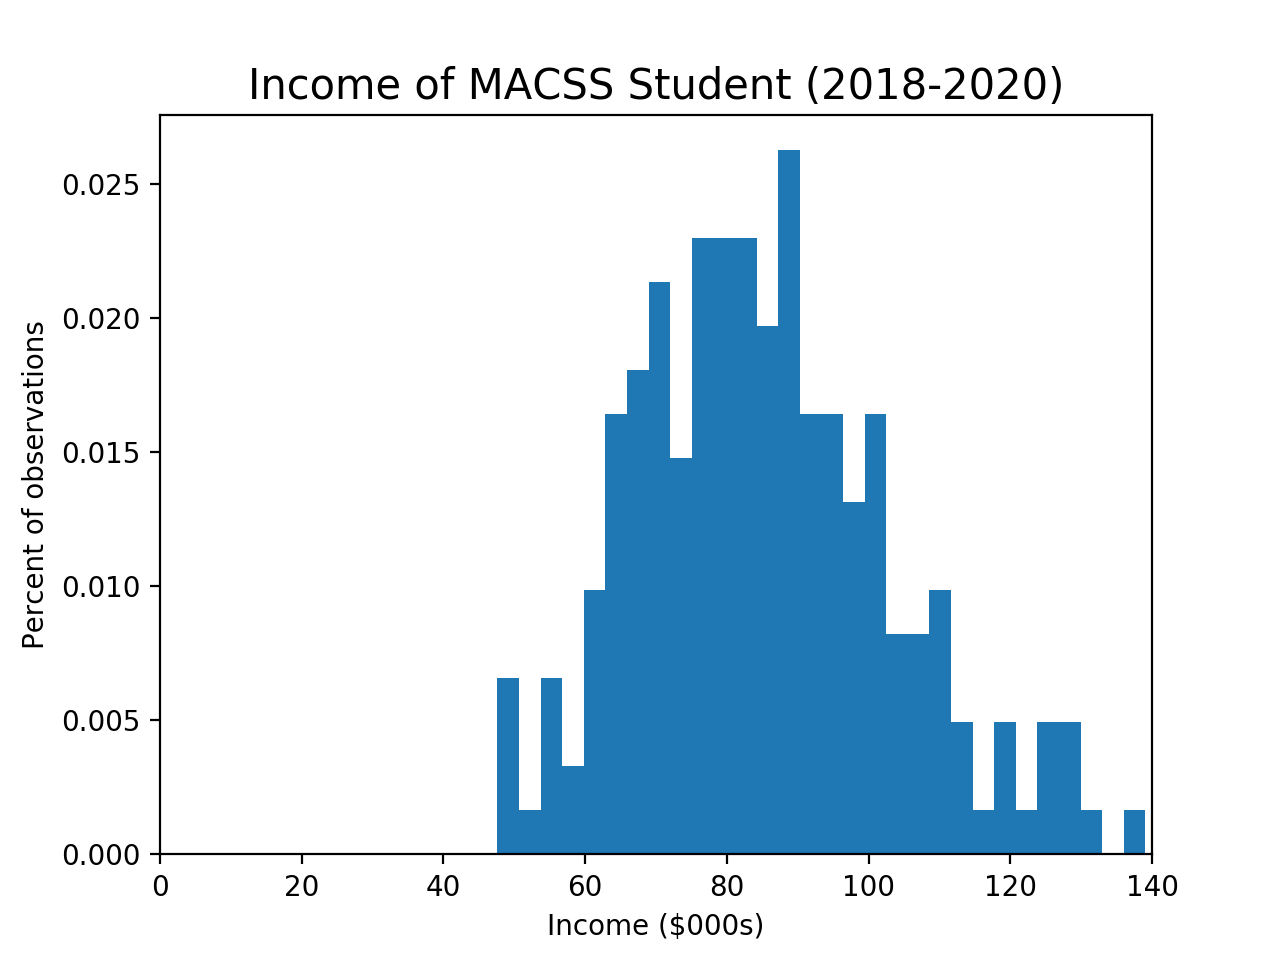

(0, 140)

In [3]:
plt.hist(income/1000, 30, normed=True)
plt.title('Income of MACSS Student (2018-2020)', fontsize=15)
plt.xlabel(r'Income (\$000s)')
plt.ylabel('Percent of observations')
plt.xlim([0, 140]) 

(b) Estimate the parameters of the lognorm distribution by GMM. Use the average income and standard deviation of inncome as your two moments. Use the identity matrix as your weighting matrix $\hat{W}$. Plot ypur estimated lognormal PDF against the histogram from part (a) Report the value of your GMM criterion function at estimated parameter values. Report and compare you two data moments against your two model moments at the estimated parameter values.

In [4]:
# probability density function (PDF)
def lognorm_pdf(xvals, mu, sigma):
    pdf_vals    = 1/ (xvals * sigma * np.sqrt(2 * np.pi)) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))
    return pdf_vals

In [19]:
def data_moments(xvals):
    mean_data = xvals.mean()
    var_data = xvals.var()
    return mean_data, var_data

def model_moments(mu, sigma):
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.01, 10**6)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.01, 10**6)
    return mean_model, var_model  

def err_vec(xvals, mu, sigma, simple=False):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

In [20]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 9
sig_init = 0.3
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
result1b = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = result1b.x
Data_Mom = data_moments(income)
Model_Mom = model_moments(mu_GMM1, sig_GMM1)

In [21]:
result1b

      fun: array([[  1.89953947e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.97050231e-06,   8.31538946e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 90
      nit: 12
   status: 0
  success: True
        x: array([ 11.33188111,   0.20869664])

In [22]:
print("Data Moment is", Data_Mom)
print("Model Moment is", Model_Mom)
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print('Value of GMM criterion function', result1b.fun)

Data Moment is (85276.823606258113, 323731572.2295289)
Model Moment is (85276.84565963816, 323731685.80127084)
mu_GMM1= 11.3318811059  sig_GMM1= 0.208696644623
Value of GMM criterion function [[  1.89953947e-13]]


<IPython.core.display.Javascript object>


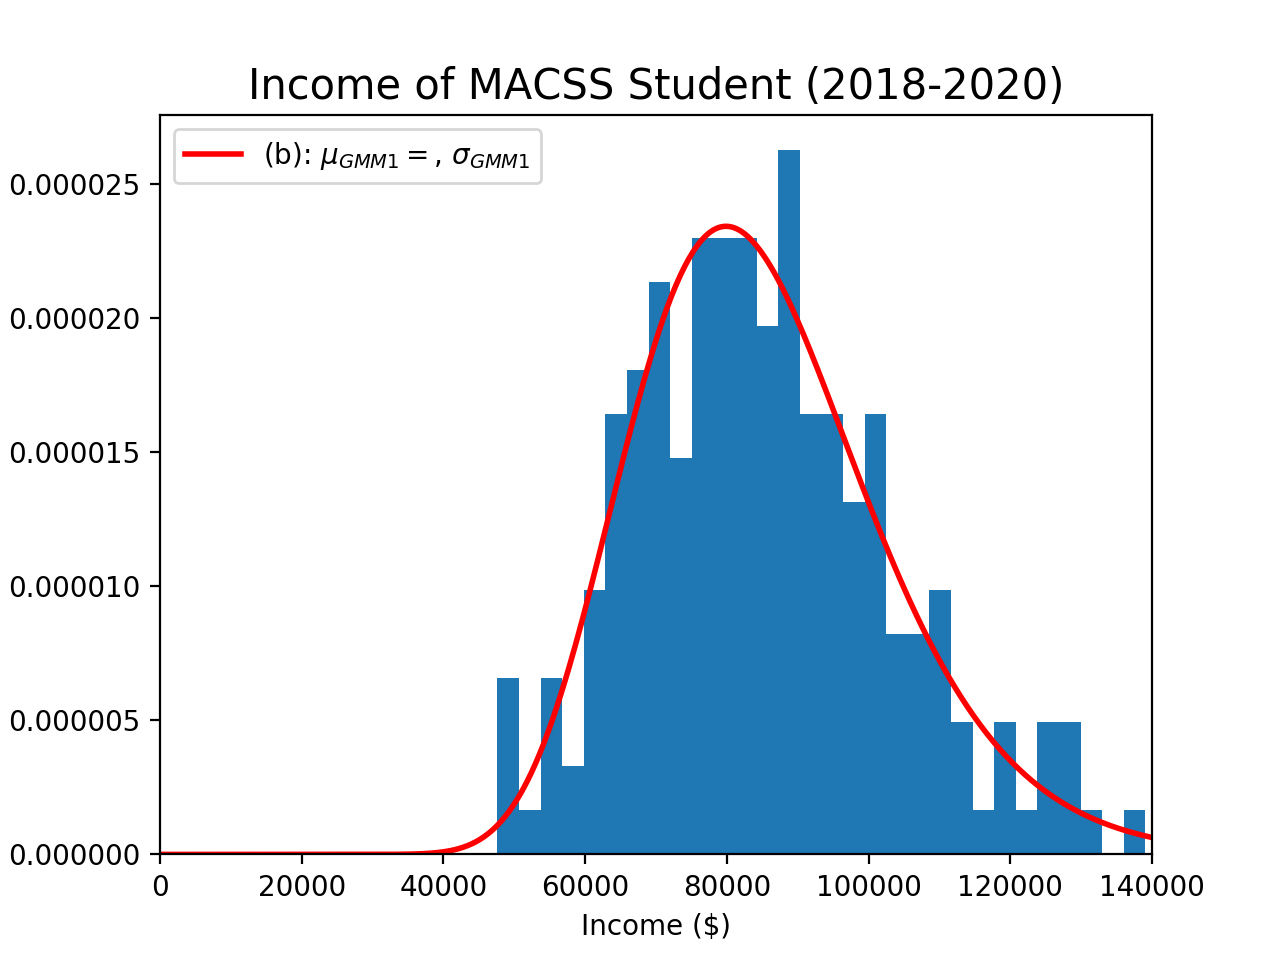

In [55]:
# Plot the histogram of the data
plt.hist(income, 30, normed=True)
plt.title('Income of MACSS Student (2018-2020)', fontsize=15)
plt.xlabel(r'Income ($)')
plt.ylabel('Percent of observations') 

# Plot the estimated GMM PDF
dist_pts = np.linspace(100, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='r', label='(b): $\mu_{GMM1}=$, $\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.xlim([0, 140000]) 
plt.show()

(c) Performe the two step GMM. Use the variance covariance matrix as weight matrix in part (b). Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram form part (a).

In [50]:
err1b = err_vec(income, mu_GMM1, sig_GMM1, False)
VCV1b = np.dot(err1b, err1b.T) / income.shape[0]
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv1b = VCV1b #* OffDiagNeg
W_hat_1c = lin.pinv(vcv1b)  # Use the pseudo-inverse calculated by SVD because VCV1b is ill-conditioned
print(W_hat_1c)

[[  3.70699196e+14   5.02878106e+14]
 [  5.02878106e+14   6.82187586e+14]]


In [51]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init_1c = 11
sig_init_1c = 0.2
params_init_1c = np.array([mu_init_1c, sig_init_1c])
gmm_args = (income, W_hat_1c)
result1c = opt.minimize(criterion, params_init_1c, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (None, None)))
mu_GMM1c, sig_GMM1c = result1b.x
Data_Mom_1c = data_moments(income)
Model_Mom_1c = model_moments(mu_GMM1c, sig_GMM1c)

In [52]:
result1c

      fun: array([[ 1.24402885]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.11763999e+08,   3.98411069e+07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 198
      nit: 7
   status: 0
  success: True
        x: array([ 11.02775353,   0.29722033])

In [54]:
print("Data Moment is", Data_Mom_1c)
print("Model Moment is", Model_Mom_1c)
print('mu_GMM1=', mu_GMM1c, ' sig_GMM1=', sig_GMM1c)
print('Value of GMM criterion function', result1c.fun)

Data Moment is (85276.823606258113, 323731572.2295289)
Model Moment is (85276.84565963816, 323731685.80127084)
mu_GMM1= 11.3318811059  sig_GMM1= 0.208696644623
Value of GMM criterion function [[ 1.24402885]]


<IPython.core.display.Javascript object>


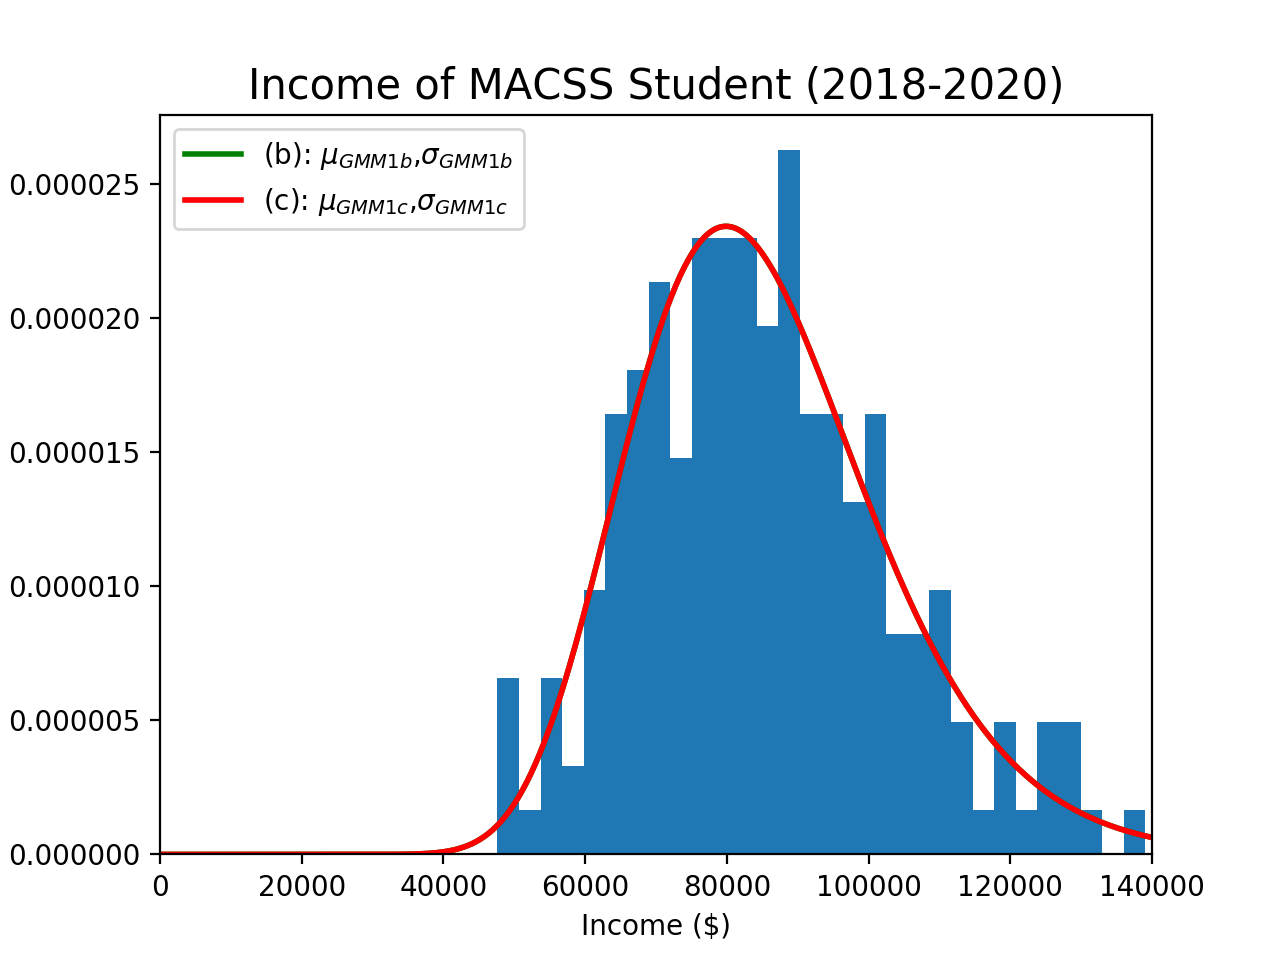

(0, 140000)

In [53]:
# Plot the histogram of the data
plt.hist(income, 30, normed=True)
plt.title('Income of MACSS Student (2018-2020)', fontsize=15)
plt.xlabel(r'Income ($)')
plt.ylabel('Percent of observations') 

# Plot the estimated GMM PDF
dist_pts = np.linspace(100, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='g', label='(b): $\mu_{GMM1b}$,$\sigma_{GMM1b}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1c, sig_GMM1c),
         linewidth=2, color='r', label='(c): $\mu_{GMM1c}$,$\sigma_{GMM1c}$')
plt.legend(loc='upper left')
plt.xlim([0, 140000]) 

The two results are almost the same, so in the graph, we are unbale to see them seperately.

In [67]:
def data_moments3(xvals):
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] / xvals.shape[0])
    bpct_3_dat = (xvals[xvals >=100000].shape[0] / xvals.shape[0])
    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma):
    xfx = lambda x: lognorm_pdf(x, mu, sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    bpct_3_mod = 1 - bpct_1_mod - bpct_2_mod
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    return err_vec


def criterion3(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    return crit_val

In [68]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init_1d = 11
sig_init_1d = 0.2
params_init_1d = np.array([mu_init_1d, sig_init_1d])
W_hat_1d = np.eye(3)
gmm_args_1d = (income, W_hat_1d)
result1d = opt.minimize(criterion3, params_init_1d, args=(gmm_args_1d),
                       method='L-BFGS-B')
mu_GMM1d, sig_GMM1d = result1d.x
Data_Mom_1d = data_moments3(income)
Model_Mom_1d = model_moments3(mu_GMM1d, sig_GMM1d)

In [69]:
result1d

      fun: array([[  2.64395919e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00030948, -0.00058658])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 16
   status: 0
  success: True
        x: array([ 11.33568133,   0.21059845])

<IPython.core.display.Javascript object>


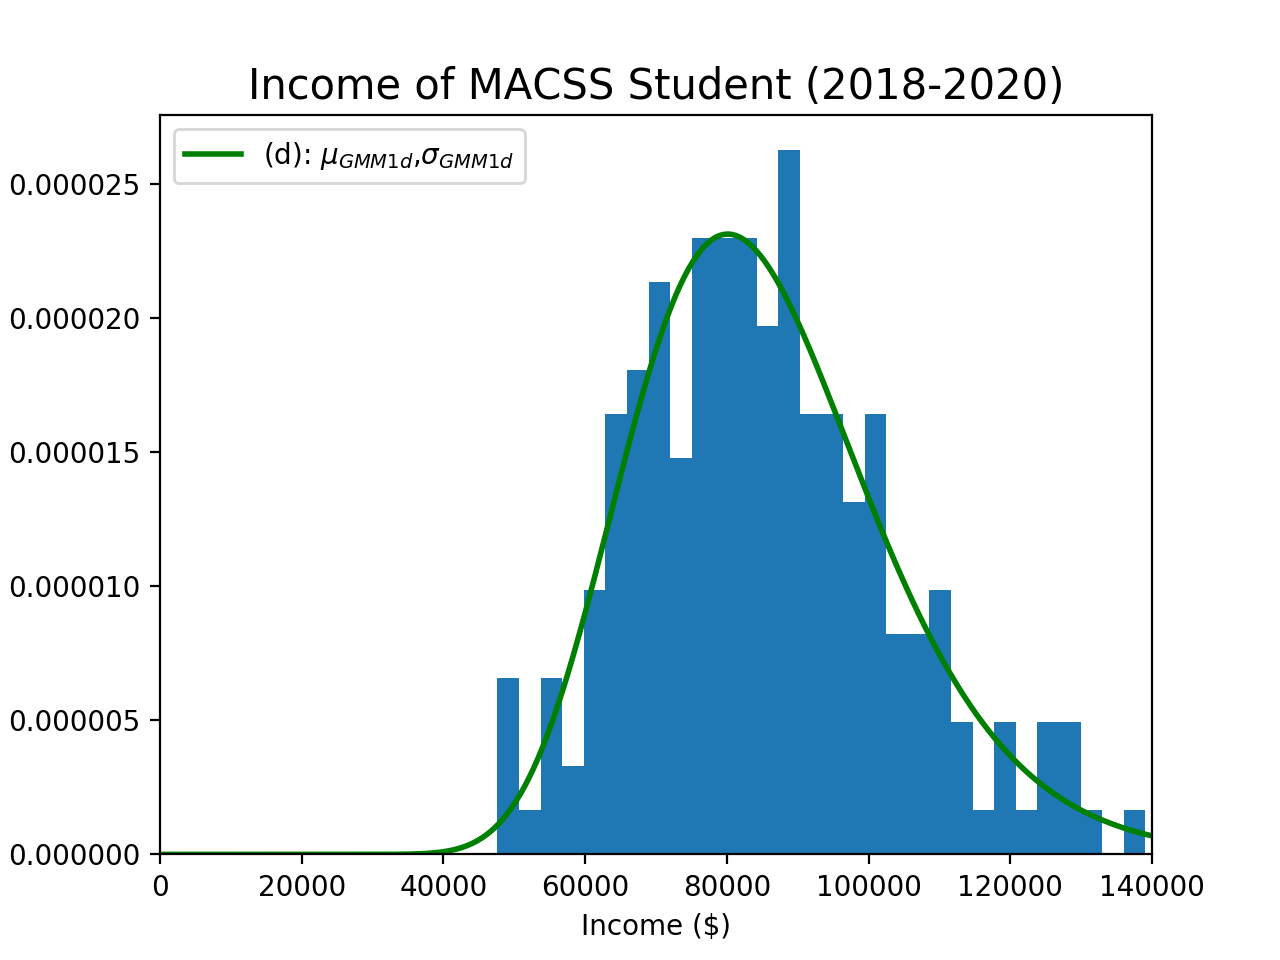

(0, 140000)

In [70]:
# Plot the histogram of the data
plt.hist(income, 30, normed=True)
plt.title('Income of MACSS Student (2018-2020)', fontsize=15)
plt.xlabel(r'Income ($)')
plt.ylabel('Percent of observations') 

# Plot the estimated GMM PDF
dist_pts = np.linspace(100, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1d, sig_GMM1d),
         linewidth=2, color='g', label='(d): $\mu_{GMM1d}$,$\sigma_{GMM1d}$')
plt.legend(loc='upper left')
plt.xlim([0, 140000]) 

In [71]:
print('GMM criterion function value are', result1d.fun)
print('Data Moments are',data_moments3(income))
print('Model Moments are',model_moments3(mu_GMM1d, sig_GMM1d))

GMM criterion function value are [[  2.64395919e-11]]
Data Moments are (0.3, 0.5, 0.2)
Model Moments are (0.3000000024535118, 0.5000000072736638, 0.19999999027282434)


(e) Perform the two-step GMM estimator by using your estimates from part. Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal against histogram in (a) and pdf in (d). Report and compare there data moments against your there model moments.

In [72]:
err1d = err_vec3(income, mu_GMM1d, sig_GMM1d, False)
VCV1d = np.dot(err1d, err1d.T) / income.shape[0]
vcv1d = VCV1d 
W_hat_1e = lin.pinv(vcv1d)  # Use the pseudo-inverse calculated by SVD because VCV1b is ill-conditioned
print(W_hat_1e)

[[  1.91361386e+11   3.40385164e+11  -1.13800500e+12]
 [  3.40385164e+11   6.05462065e+11  -2.02423292e+12]
 [ -1.13800500e+12  -2.02423292e+12   6.76758984e+12]]


In [73]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
gmm_args = (income, W_hat_1e)
result1e = opt.minimize(criterion3, params_init, args=(gmm_args),
                       method='L-BFGS-B')
mu_GMM1e, sig_GMM1e = result1d.x
Data_Mom_1e = data_moments(income)
Model_Mom_1e = model_moments(mu_GMM1e, sig_GMM1e)

In [74]:
result1e

      fun: array([[ 12.65217902]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.43573455e+08,  -4.16756764e+07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 5
   status: 0
  success: True
        x: array([ 11.09829943,   0.48841575])

<IPython.core.display.Javascript object>


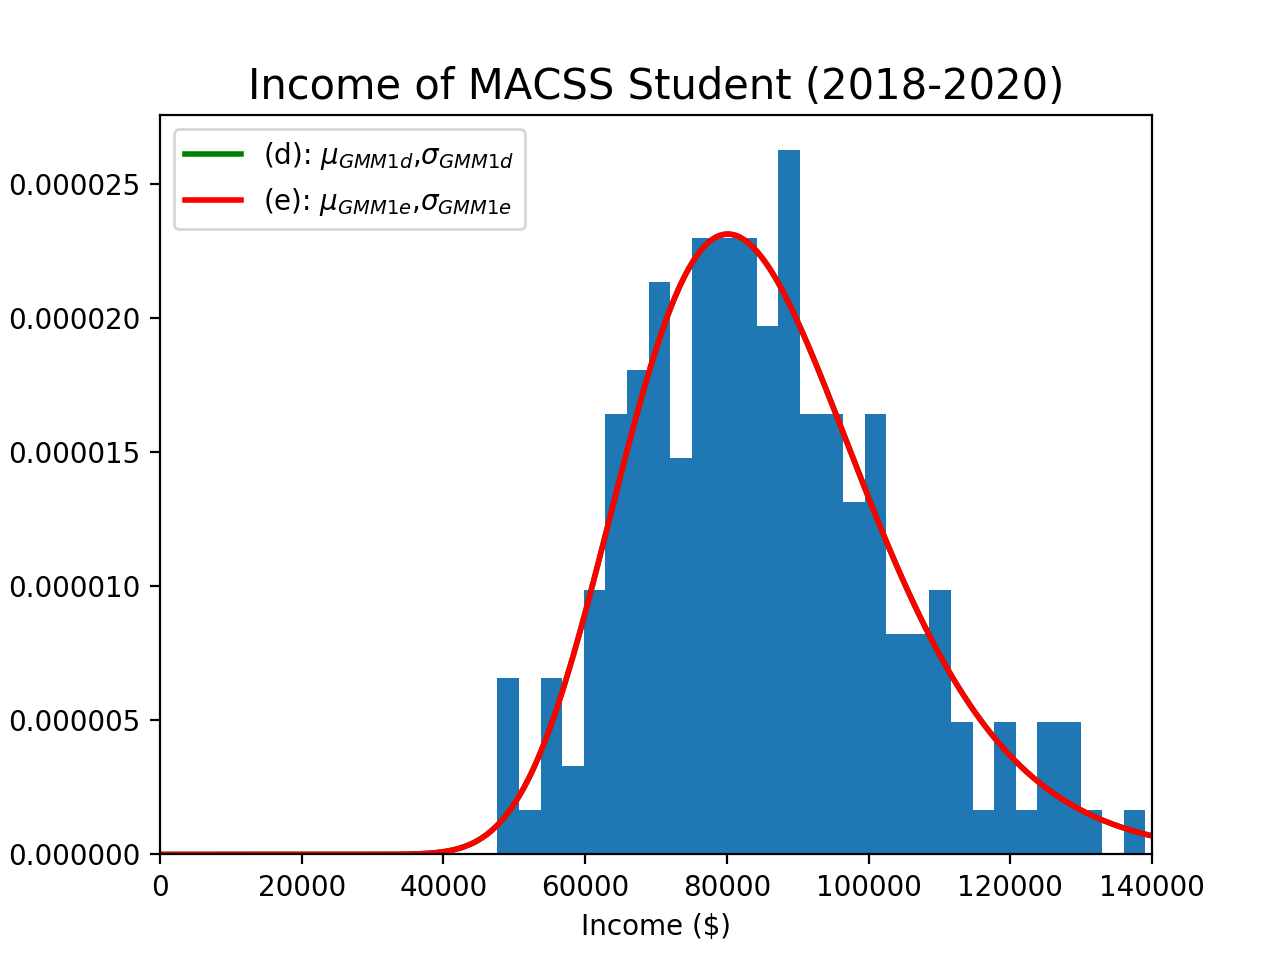

(0, 140000)

In [75]:
# Plot the histogram of the data
plt.hist(income, 30, normed=True)
plt.title('Income of MACSS Student (2018-2020)', fontsize=15)
plt.xlabel(r'Income ($)')
plt.ylabel('Percent of observations') 

# Plot the estimated GMM PDF
dist_pts = np.linspace(100, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1d, sig_GMM1d),
         linewidth=2, color='g', label='(d): $\mu_{GMM1d}$,$\sigma_{GMM1d}$')
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1e, sig_GMM1e),
         linewidth=2, color='r', label='(e): $\mu_{GMM1e}$,$\sigma_{GMM1e}$')
plt.legend(loc='upper left')
plt.xlim([0, 140000]) 

In [76]:
print('GMM criterion function value are', result1e.fun)
print('Data Moments are',data_moments3(income))
print('Model Moments are',model_moments3(mu_GMM1e, sig_GMM1e))

GMM criterion function value are [[ 12.65217902]]
Data Moments are (0.3, 0.5, 0.2)
Model Moments are (0.3000000024535118, 0.5000000072736638, 0.19999999027282434)


(f) In general I think they are basically similar results. If we use criterion function we could see that 1b has the smallest value and 1e has the largest value.

# Question 2 
Linear regression and GMM.

(a) Estimate the parameters of the model by GMM by solving the minimization problem of the GMM criterion function. Use the identity matrix as the estimator for the optimal weighting matrix.

In [107]:
import pandas as pd
data = pd.read_csv('sick.txt', encoding = 'utf-8-sig')

In [108]:
data[:2]

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54


In [111]:
def err_ols(data, *params):
    b0, b1, b2, b3 = params
    err_vec = data.sick - (b0 + b1 * data.age + b2 * data.children + b3 * data.avgtemp_winter)
    return (err_vec)

def criterion_ols(params, args):
    data = args
    W = np.eye(len(data))
    err = err_ols(data, *params)
    crit_val = np.dot(np.dot(err.T, W), err)
    return (crit_val)

In [115]:
params_init = np.array([0, 0, 0, 0])
results = opt.minimize(criterion_ols,  params_init, args=data, method = 'L-BFGS-B')
beta_vec = results.x
print('Parameter we estimated are', beta_vec)
print('GMM Criterion function value are', criterion_ols(np.array(beta_vec), sick_data) )

Parameter we estimated are [ 0.25164524  0.01293354  0.40050046 -0.00999176]
GMM Criterion function value are 0.00182128979591
